In [1]:
import matplotlib.pyplot as plt
import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv2D
from lcapt.preproc import standardize_inputs
from lcapt.metric import compute_l1_sparsity, compute_l2_error

In [2]:
BATCH_SIZE = 64
EPOCHS = 20
FEATURES = 64  # number of dictionary features to learn
KERNEL_SIZE = 9  # height and width of each feature
LEARNING_RATE = 1e-2
LAMBDA = 0.25  # LCA threshold
PRINT_FREQ = 10
STRIDE = 2  # convolutional stride
TAU = 200  # LCA time constant

In [ ]:
dset = CIFAR10('./data', download=True, transform=ToTensor())
dataloader = DataLoader(dset, BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

In [4]:
lca = LCAConv2D(
    n_neurons=FEATURES,
    in_c=3,
    result_dir='./cifar_dictionary_learning',
    kh=KERNEL_SIZE,
    kw=KERNEL_SIZE,
    stride_h=STRIDE,
    stride_w=STRIDE,
    lambda_=LAMBDA,
    tau=TAU,
    track_metrics=False,
    req_grad=True,
    input_norm=False
)
if torch.cuda.is_available():
    lca = torch.nn.DataParallel(lca).cuda()

In [5]:
optimizer = SGD(lca.parameters(), LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, len(dset) // BATCH_SIZE, 1e-5)

In [6]:
l1, l2, energy = [], [], []

In [ ]:
for epoch in range(EPOCHS):
    for batch_num, (images, _) in enumerate(dataloader):
        images = standardize_inputs(images)
        images = images.cuda()
        with torch.no_grad():
            code = lca(images)

        recon = lca.module.compute_recon(code, lca.module.weights)
        l1_sparsity = l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_)
        l2_recon_error = compute_l2_error(images, recon)
        total_energy = l2_recon_error + l1_sparsity
        total_energy.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        lca.module.normalize_weights()

        l1.append(l1_sparsity.item())
        l2.append(l2_recon_error.item())
        energy.append(total_energy.item())

        if (batch_num + 1) % PRINT_FREQ == 0:
            print(f'Epoch: {epoch + 1}; ',
                  f'Batch: {batch_num + 1}; ',
                  f'L2 Recon Error: {round(l2[-1], 2)}; ',
                  f'L1 Sparsity: {round(l1[-1], 2)}; ',
                  f'Total Energy: {round(energy[-1], 2)}')

    torch.save(lca, f'save_{epoch}.pth')
    scheduler = CosineAnnealingLR(optimizer, len(dset) // BATCH_SIZE, 1e-5)

Text(0.5, 0, 'Step Number')

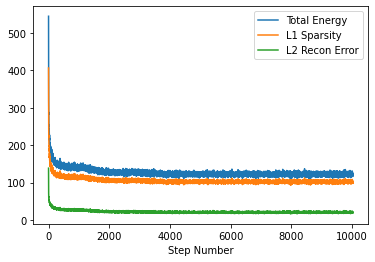

In [26]:
plt.plot(energy, label='Total Energy')
plt.plot(l1, label='L1 Sparsity')
plt.plot(l2, label='L2 Recon Error')
plt.legend()
plt.xlabel('Step Number')

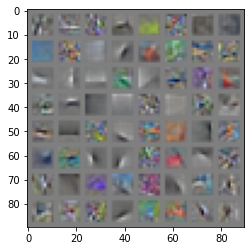

In [27]:
weight_grid = make_feature_grid(lca.module.get_weights())
plt.imshow(weight_grid.cpu().numpy())